In [57]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

import optuna.visualization as vis
import xgboost as xgb 

import numpy as np
import optuna
import sys
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import joblib
from sklearn.model_selection import train_test_split


## Loading Data

In [58]:
train_val = pd.read_csv('../split_year_data/train_val.csv')
train_val = train_val.drop(columns=['Unnamed: 0'], axis=1)

train_val_low = train_val[train_val['income_num'] == 1]
train_val_input_low = train_val_low.drop(columns=['setting', 'date', 'Maternal mortality ratio (national estimate, per 100,000 live births)'], axis=1)
train_val_label_low = train_val_low['Maternal mortality ratio (national estimate, per 100,000 live births)']

train_val_ul = train_val[train_val['income_num'] == 2]
train_val_input_ul = train_val_ul.drop(columns=['setting', 'date', 'Maternal mortality ratio (national estimate, per 100,000 live births)'], axis=1)
train_val_label_ul = train_val_ul['Maternal mortality ratio (national estimate, per 100,000 live births)']

train_val_um = train_val[train_val['income_num'] == 3]
train_val_input_um = train_val_um.drop(columns=['setting', 'date', 'Maternal mortality ratio (national estimate, per 100,000 live births)'], axis=1)
train_val_label_um = train_val_um['Maternal mortality ratio (national estimate, per 100,000 live births)']

train_val_high = train_val[train_val['income_num'] == 4]
train_val_input_high = train_val_high.drop(columns=['setting', 'date', 'Maternal mortality ratio (national estimate, per 100,000 live births)'], axis=1)
train_val_label_high = train_val_high['Maternal mortality ratio (national estimate, per 100,000 live births)']

## Predictions From Base Estimators 

### Function

In [59]:
def get_predictions(model_name, features, sensitivity, train_val_data):
    tvd = train_val_data.copy()
    models = []
    train_val_predictions = []
    test_predictions = []

    for fold, fold_num in enumerate(['0', '1', '2', '3', '4']):
        for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']):
            #if features == 'corr_80' and thresh == 0:
            #    continue 
            #if features == 'corr_80' and thresh == 1 and (fold==1 or fold==3 or fold==4):
            #    continue
            
            if thresh == 0:
                name = '85'
            elif thresh == 1:
                name = '90'
            elif thresh == 2:
                name = '95'
            else: name = '1'

            best_p = joblib.load(f"{sensitivity}_year/{model_name}/best_params_{fold}_{name}_{features}.pkl")

            train_data_file = 'year_data/' + sensitivity + '_year.pkl'
            with open(train_data_file, 'rb') as f:
                train_data = joblib.load(f)

            train_x = train_data[int(fold)][features][thresh*2].copy()
            train_x = train_x.drop(columns=['index'], axis=1)
            train_y = train_data[int(fold)][features][thresh*2 + 1].copy()

            test_data_file = 'year_data/test_' +  sensitivity + '_year.pkl'
            with open(test_data_file, 'rb') as f:
                test_data = joblib.load(f)
            test_x = test_data[0].drop(columns=['Unnamed: 0'])
            test_y = test_data[1]

            if model_name == 'rf':
                loaded_model = RandomForestRegressor(**best_p)
                
            elif model_name == 'xgb':
                loaded_model = xgb.XGBRegressor(**best_p)

            elif model_name == 'lgb':
                train_x.columns = train_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
                train_y.column = 'Maternal mortality ratio (national estimate per 100000 live births)'
                tvd.columns = tvd.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
                test_x.columns = test_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

                loaded_model = lgb.LGBMRegressor(**best_p, verbosity = -1)     

            train_load = loaded_model.fit(train_x, train_y)
            models.append(train_load)
            
            train_val_input_relevant = tvd[train_x.columns].copy()
            train_val_predictions.append(train_load.predict(train_val_input_relevant))
            
            test_relevant = test_x[train_x.columns].copy()
            test_predictions.append(train_load.predict(test_relevant))

    return models, train_val_predictions, test_predictions

### Utilising Function

predictions_lgb + predictions_rf + predictions_xgb

0-19: lightgbm all features
20-39: lightgbm literature features
40-59: lightgbm correlation 60
60-79: lightgbm correlation 70
80-99: lightgbm correlation 80

100-119: random forest all features
120-139: random forest literature features
140-159: random forest correlation 70
160-179: random forest correlation 60
180-199: random forest correlation 80

200-219: xgboost all features
220-239: xgboost literature features
240-259: xgboost forest correlation 60
260-279: xgboost forest correlation 70
280-299: xgboost forest correlation 80

### Low

In [15]:
rf_models_low = []
rf_predictions_low = []
rf_test_predictions_low = []

xgb_models_low = []
xgb_predictions_low = []
xgb_test_predictions_low = []

lgbm_models_low = []
lgbm_predictions_low = []
lgbm_test_predictions_low = []

In [16]:
for model_name in ['lgb', 'rf', 'xgb']:
    for feature in ['full', 'lit', 'corr_60', 'corr_70', 'corr_80']:
        model, pred, test_pred = get_predictions(model_name, feature, 'low', train_val_input_low)
    
        if model_name == 'lgb':
            lgbm_models_low.append(model)
            for p in pred:
                lgbm_predictions_low.append(p)
            for pt in test_pred:
                lgbm_test_predictions_low.append(pt)

        if model_name == 'rf':
            rf_models_low.append(model)
            for p in pred:
                rf_predictions_low.append(p)
            for pt in test_pred:
                rf_test_predictions_low.append(pt)

        if model_name == 'xgb':
            xgb_models_low.append(model)
            for p in pred:
                xgb_predictions_low.append(p)
            for pt in test_pred:
                xgb_test_predictions_low.append(pt)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

In [17]:
full_predictions_low = lgbm_predictions_low + rf_predictions_low + xgb_predictions_low
stacked_predictions_low = np.column_stack(full_predictions_low)
joblib.dump(stacked_predictions_low, f"ensemble/year/stacked_predictions_low.pkl")

full_test_predictions_low = lgbm_test_predictions_low + rf_test_predictions_low + xgb_test_predictions_low
stacked_test_predictions_low = np.column_stack(full_test_predictions_low)
joblib.dump(stacked_test_predictions_low, f"ensemble/year/stacked_test_predictions_low.pkl")

['ensemble/year/stacked_test_predictions_low.pkl']

In [18]:
len(lgbm_predictions_low), len(rf_predictions_low), len(xgb_predictions_low)

(100, 100, 100)

In [19]:
train_val_label_low.shape, train_val_input_low.shape

((71,), (71, 720))

In [20]:
stacked_predictions_low.shape

(71, 300)

In [21]:
X_meta_train_low, X_meta_val_low, y_meta_train_low, y_meta_val_low = train_test_split(
    stacked_predictions_low, train_val_label_low, test_size=0.2, random_state=42
)

### Lower Middle

In [60]:
rf_models_ul = []
rf_predictions_ul = []
rf_test_predictions_ul = []

xgb_models_ul = []
xgb_predictions_ul = []
xgb_test_predictions_ul = []

lgbm_models_ul = []
lgbm_predictions_ul = []
lgbm_test_predictions_ul = []

In [61]:
for model_name in ['lgb', 'rf', 'xgb']:
    for feature in ['full', 'lit', 'corr_60', 'corr_70', 'corr_80']:
        model, pred, test_pred = get_predictions(model_name, feature, 'ul', train_val_input_ul)
    
        if model_name == 'lgb':
            lgbm_models_ul.append(model)
            for p in pred:
                lgbm_predictions_ul.append(p)
            for pt in test_pred:
                lgbm_test_predictions_ul.append(pt)

        if model_name == 'rf':
            rf_models_ul.append(model)
            for p in pred:
                rf_predictions_ul.append(p)
            for pt in test_pred:
                rf_test_predictions_ul.append(pt)

        if model_name == 'xgb':
            xgb_models_ul.append(model)
            for p in pred:
                xgb_predictions_ul.append(p)
            for pt in test_pred:
                xgb_test_predictions_ul.append(pt)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

In [62]:
full_predictions_ul = lgbm_predictions_ul + rf_predictions_ul + xgb_predictions_ul
stacked_predictions_ul = np.column_stack(full_predictions_ul)
joblib.dump(stacked_predictions_ul, f"ensemble/year/stacked_predictions_ul.pkl")

full_test_predictions_ul = lgbm_test_predictions_ul + rf_test_predictions_ul + xgb_test_predictions_ul
stacked_test_predictions_ul = np.column_stack(full_test_predictions_ul)
joblib.dump(stacked_test_predictions_ul, f"ensemble/year/stacked_test_predictions_ul.pkl")

['ensemble/year/stacked_test_predictions_ul.pkl']

In [63]:
X_meta_train_ul, X_meta_val_ul, y_meta_train_ul, y_meta_val_ul = train_test_split(
    stacked_predictions_ul, train_val_label_ul, test_size=0.2, random_state=42
)

### Upper Middle

In [71]:
rf_models_um = []
rf_predictions_um = []
rf_test_predictions_um = []

xgb_models_um = []
xgb_predictions_um = []
xgb_test_predictions_um = []

lgbm_models_um = []
lgbm_predictions_um = []
lgbm_test_predictions_um = []

In [72]:
for model_name in ['lgb', 'rf', 'xgb']:
    for feature in ['full', 'lit', 'corr_60', 'corr_70', 'corr_80']:
        model, pred, test_pred = get_predictions(model_name, feature, 'um', train_val_input_um)
    
        if model_name == 'lgb':
            lgbm_models_um.append(model)
            for p in pred:
                lgbm_predictions_um.append(p)
            for pt in test_pred:
                lgbm_test_predictions_um.append(pt)

        if model_name == 'rf':
            rf_models_um.append(model)
            for p in pred:
                rf_predictions_um.append(p)
            for pt in test_pred:
                rf_test_predictions_um.append(pt)

        if model_name == 'xgb':
            xgb_models_um.append(model)
            for p in pred:
                xgb_predictions_um.append(p)
            for pt in test_pred:
                xgb_test_predictions_um.append(pt)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

In [73]:
full_predictions_um = lgbm_predictions_um + rf_predictions_um + xgb_predictions_um
stacked_predictions_um = np.column_stack(full_predictions_um)
joblib.dump(stacked_predictions_um, f"ensemble/year/stacked_predictions_um.pkl")

full_test_predictions_um = lgbm_test_predictions_um + rf_test_predictions_um + xgb_test_predictions_um
stacked_test_predictions_um = np.column_stack(full_test_predictions_um)
joblib.dump(stacked_test_predictions_um, f"ensemble/year/stacked_test_predictions_um.pkl")

['ensemble/year/stacked_test_predictions_um.pkl']

In [74]:
(stacked_predictions_um.shape)

(926, 300)

In [75]:
X_meta_train_um, X_meta_val_um, y_meta_train_um, y_meta_val_um = train_test_split(
    stacked_predictions_um, train_val_label_um, test_size=0.2, random_state=42
)

### High

In [58]:
rf_models_high = []
rf_predictions_high = []
rf_test_predictions_high = []

xgb_models_high = []
xgb_predictions_high = []
xgb_test_predictions_high = []

lgbm_models_high = []
lgbm_predictions_high = []
lgbm_test_predictions_high = []

In [59]:
for model_name in ['lgb', 'rf', 'xgb']:
    for feature in ['full', 'lit', 'corr_60', 'corr_70', 'corr_80']:
        model, pred, test_pred = get_predictions(model_name, feature, 'high', train_val_input_high)
    
        if model_name == 'lgb':
            lgbm_models_high.append(model)
            for p in pred:
                lgbm_predictions_high.append(p)
            for pt in test_pred:
                lgbm_test_predictions_high.append(pt)

        if model_name == 'rf':
            rf_models_high.append(model)
            for p in pred:
                rf_predictions_high.append(p)
            for pt in test_pred:
                rf_test_predictions_high.append(pt)

        if model_name == 'xgb':
            xgb_models_high.append(model)
            for p in pred:
                xgb_predictions_high.append(p)
            for pt in test_pred:
                xgb_test_predictions_high.append(pt)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

In [60]:
train_data_file = 'year_data/high_year.pkl'
with open(train_data_file, 'rb') as f:
    train_data = joblib.load(f)
train_data[4]['corr_80'][0]

,index
0,4
1,5
2,8
3,11
4,12
...,...
1043,2065
1044,2066
1045,2067
1046,2068


In [61]:
full_predictions_high = lgbm_predictions_high + rf_predictions_high + xgb_predictions_high
stacked_predictions_high = np.column_stack(full_predictions_high)
joblib.dump(stacked_predictions_high, f"ensemble/year/stacked_predictions_high.pkl")

full_test_predictions_high = lgbm_test_predictions_high + rf_test_predictions_high + xgb_test_predictions_high
stacked_test_predictions_high = np.column_stack(full_test_predictions_high)
joblib.dump(stacked_test_predictions_high, f"ensemble/year/stacked_test_predictions_high.pkl")

['ensemble/year/stacked_test_predictions_high.pkl']

In [62]:
X_meta_train_high, X_meta_val_high, y_meta_train_high, y_meta_val_high = train_test_split(
    stacked_predictions_high, train_val_label_high, test_size=0.2, random_state=42
)

## Training Random Forest Ensemble

### Objective Function

In [64]:
def stacked_objective_rf(trial, X_meta_train, y_meta_train, X_meta_val, y_meta_val):

    n_trees = trial.suggest_int("n_estimators", 10, 300)

    max_depth = trial.suggest_int("max_depth", 3, 25)

    min_sample_split = trial.suggest_int("min_samples_split", 2, 10)

    bootstrapping = trial.suggest_categorical("bootstrap", [True, False])
    if bootstrapping == False:
        max_samples = None
    else:
        max_samples = trial.suggest_float("max_samples", 0.01, 1.0)

    rf = RandomForestRegressor(random_state=42, n_jobs=-1, min_samples_split=min_sample_split, bootstrap=bootstrapping, max_samples=max_samples, n_estimators=n_trees, max_depth=max_depth)
    
    rf.fit(X_meta_train, y_meta_train)
    rf_predictions = rf.predict(X_meta_val)

    return mean_squared_error(y_meta_val, rf_predictions)

### Building Ensemble Models

In [30]:
rf_stacking_study_low = optuna.create_study(direction='minimize')
rf_stacking_study_low.optimize(lambda trial: stacked_objective_rf(trial, X_meta_train_low, y_meta_train_low, X_meta_val_low, y_meta_val_low), n_trials=1000)
joblib.dump(rf_stacking_study_low.best_params, f"ensemble/year/rf_stacking_best_params_low.pkl")
joblib.dump(rf_stacking_study_low, f"ensemble/year/rf_stacking_optuna_study_low.pkl")

best_rf_model_low = RandomForestRegressor(**rf_stacking_study_low.best_params)
best_rf_model_low.fit(stacked_predictions_low, train_val_label_low)
joblib.dump(best_rf_model_low, "ensemble/year/rf_stacking_best_model_low.pkl")

[I 2025-09-03 11:43:23,774] A new study created in memory with name: no-name-8853eb9d-3883-4331-a384-7685d26317b8


[I 2025-09-03 11:43:23,925] Trial 0 finished with value: 2697.0542726551766 and parameters: {'n_estimators': 136, 'max_depth': 15, 'min_samples_split': 7, 'bootstrap': True, 'max_samples': 0.7278950800361381}. Best is trial 0 with value: 2697.0542726551766.
[I 2025-09-03 11:43:23,972] Trial 1 finished with value: 9507.962926840419 and parameters: {'n_estimators': 45, 'max_depth': 10, 'min_samples_split': 6, 'bootstrap': False}. Best is trial 0 with value: 2697.0542726551766.
[I 2025-09-03 11:43:24,111] Trial 2 finished with value: 2292.862356029446 and parameters: {'n_estimators': 183, 'max_depth': 25, 'min_samples_split': 6, 'bootstrap': True, 'max_samples': 0.8391823978322236}. Best is trial 2 with value: 2292.862356029446.
[I 2025-09-03 11:43:24,205] Trial 3 finished with value: 9257.990804407715 and parameters: {'n_estimators': 110, 'max_depth': 8, 'min_samples_split': 2, 'bootstrap': False}. Best is trial 2 with value: 2292.862356029446.
[I 2025-09-03 11:43:24,242] Trial 4 finishe

['ensemble/year/rf_stacking_best_model_low.pkl']

In [65]:
rf_stacking_study_ul = optuna.create_study(direction='minimize')
rf_stacking_study_ul.optimize(lambda trial: stacked_objective_rf(trial, X_meta_train_ul, y_meta_train_ul, X_meta_val_ul, y_meta_val_ul), n_trials=1000)
joblib.dump(rf_stacking_study_ul.best_params, f"ensemble/year/rf_stacking_best_params_ul.pkl")
joblib.dump(rf_stacking_study_ul, f"ensemble/year/rf_stacking_optuna_study_ul.pkl")

best_rf_model_ul = RandomForestRegressor(**rf_stacking_study_ul.best_params)
best_rf_model_ul.fit(stacked_predictions_ul, train_val_label_ul)
joblib.dump(best_rf_model_ul, "ensemble/year/rf_stacking_best_model_ul.pkl")

[I 2025-10-07 19:29:07,400] A new study created in memory with name: no-name-45b106e5-915c-4792-9385-48847ab112cd
[I 2025-10-07 19:29:10,575] Trial 0 finished with value: 2469.900278017485 and parameters: {'n_estimators': 171, 'max_depth': 10, 'min_samples_split': 9, 'bootstrap': False}. Best is trial 0 with value: 2469.900278017485.
[I 2025-10-07 19:29:14,137] Trial 1 finished with value: 1804.2434660603228 and parameters: {'n_estimators': 194, 'max_depth': 23, 'min_samples_split': 6, 'bootstrap': False}. Best is trial 1 with value: 1804.2434660603228.
[I 2025-10-07 19:29:17,202] Trial 2 finished with value: 1677.8229169530312 and parameters: {'n_estimators': 162, 'max_depth': 8, 'min_samples_split': 3, 'bootstrap': False}. Best is trial 2 with value: 1677.8229169530312.
[I 2025-10-07 19:29:18,901] Trial 3 finished with value: 2451.8196814553594 and parameters: {'n_estimators': 98, 'max_depth': 22, 'min_samples_split': 9, 'bootstrap': False}. Best is trial 2 with value: 1677.822916953

['ensemble/year/rf_stacking_best_model_ul.pkl']

In [76]:
rf_stacking_study_um = optuna.create_study(direction='minimize')
rf_stacking_study_um.optimize(lambda trial: stacked_objective_rf(trial, X_meta_train_um, y_meta_train_um, X_meta_val_um, y_meta_val_um), n_trials=1000)
joblib.dump(rf_stacking_study_um.best_params, f"ensemble/year/rf_stacking_best_params_um.pkl")
joblib.dump(rf_stacking_study_um, f"ensemble/year/rf_stacking_optuna_study_um.pkl")

best_rf_model_um = RandomForestRegressor(**rf_stacking_study_um.best_params)
best_rf_model_um.fit(stacked_predictions_um, train_val_label_um)
joblib.dump(best_rf_model_um, "ensemble/year/rf_stacking_best_model_um.pkl")

[I 2025-09-06 21:57:02,842] A new study created in memory with name: no-name-3003e4fb-3533-4346-a864-b9b0b264a747
[I 2025-09-06 21:57:03,846] Trial 0 finished with value: 155.08206832644697 and parameters: {'n_estimators': 72, 'max_depth': 25, 'min_samples_split': 3, 'bootstrap': False}. Best is trial 0 with value: 155.08206832644697.
[I 2025-09-06 21:57:04,035] Trial 1 finished with value: 181.0724757292104 and parameters: {'n_estimators': 13, 'max_depth': 17, 'min_samples_split': 9, 'bootstrap': False}. Best is trial 0 with value: 155.08206832644697.
[I 2025-09-06 21:57:05,594] Trial 2 finished with value: 64.93860654141422 and parameters: {'n_estimators': 224, 'max_depth': 24, 'min_samples_split': 8, 'bootstrap': True, 'max_samples': 0.8941405886651366}. Best is trial 2 with value: 64.93860654141422.
[I 2025-09-06 21:57:09,324] Trial 3 finished with value: 167.39501287346465 and parameters: {'n_estimators': 275, 'max_depth': 8, 'min_samples_split': 9, 'bootstrap': False}. Best is tr

['ensemble/year/rf_stacking_best_model_um.pkl']

In [63]:
rf_stacking_study_high = optuna.create_study(direction='minimize')
rf_stacking_study_high.optimize(lambda trial: stacked_objective_rf(trial, X_meta_train_high, y_meta_train_high, X_meta_val_high, y_meta_val_high), n_trials=1000)
joblib.dump(rf_stacking_study_high.best_params, f"ensemble/year/rf_stacking_best_params_high.pkl")
joblib.dump(rf_stacking_study_high, f"ensemble/year/rf_stacking_optuna_study_high.pkl")

best_rf_model_high = RandomForestRegressor(**rf_stacking_study_high.best_params)
best_rf_model_high.fit(stacked_predictions_high, train_val_label_high)
joblib.dump(best_rf_model_high, "ensemble/year/rf_stacking_best_model_high.pkl")

[I 2025-09-04 11:22:59,607] A new study created in memory with name: no-name-8a87af35-0c74-4e0d-8299-f03b737c1f3a
[I 2025-09-04 11:23:06,823] Trial 0 finished with value: 3.669122304832943 and parameters: {'n_estimators': 272, 'max_depth': 11, 'min_samples_split': 2, 'bootstrap': False}. Best is trial 0 with value: 3.669122304832943.
[I 2025-09-04 11:23:08,190] Trial 1 finished with value: 5.8057199761062925 and parameters: {'n_estimators': 60, 'max_depth': 23, 'min_samples_split': 10, 'bootstrap': False}. Best is trial 0 with value: 3.669122304832943.
[I 2025-09-04 11:23:09,803] Trial 2 finished with value: 8.418076439061199 and parameters: {'n_estimators': 105, 'max_depth': 5, 'min_samples_split': 9, 'bootstrap': False}. Best is trial 0 with value: 3.669122304832943.
[I 2025-09-04 11:23:10,551] Trial 3 finished with value: 17.882133536027336 and parameters: {'n_estimators': 135, 'max_depth': 20, 'min_samples_split': 6, 'bootstrap': True, 'max_samples': 0.3333782261476376}. Best is tr

['ensemble/year/rf_stacking_best_model_high.pkl']

## Evaluating Ensembles

### Loading Data

In [85]:
output_dir = '../split_year_models'
output_dir_fromlit = '../fs_fromlit_models'
output_dir_corr = '../feature_selection_models/by_year'

In [86]:
filepath = '../split_year_data'

In [87]:
train = {}
for fold in range(0, 5):
    tdata_x85 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_85.csv')
    tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y85 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_85.csv')
    tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x90 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_90.csv')
    tdata_x90 = tdata_x90.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y90 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_90.csv')
    tdata_y90 = tdata_y90.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x95 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_95.csv')
    tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y95 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_95.csv')
    tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x1 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_1.csv')
    tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y1 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_1.csv')
    tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

    train[fold] = [tdata_x85, tdata_y85, tdata_x90, tdata_y90, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

In [88]:
test_data_x = pd.read_csv(filepath + '/test/X_test.csv')
test_data_x = test_data_x.drop(columns=['Unnamed: 0'], axis=1)
test_data_y = pd.read_csv(filepath + '/test/y_test.csv')
test_data_y = test_data_y.drop(columns=['Unnamed: 0'], axis=1)

In [89]:
filepath_lit = '../fs_fromlit_data'

test_data_x_lit_income = pd.read_csv(filepath_lit + '/year/test/X_test.csv')
test_data_x_lit_income = test_data_x_lit_income.drop(columns=['Unnamed: 0'], axis=1)
test_data_y_lit_income = pd.read_csv(filepath_lit + '/year/test/y_test.csv')
test_data_y_lit_income = test_data_y_lit_income.drop(columns=['Unnamed: 0'], axis=1)
test_data_lit_income = pd.concat([test_data_x_lit_income, test_data_y_lit_income])

validation_lit_income = {}

for fold in range(0, 5):
    vdata_xinc = pd.read_csv(filepath_lit + '/year/val/X_val_' + str(fold) + '.csv')
    vdata_xinc = vdata_xinc.drop(columns=['Unnamed: 0'], axis=1)
    vdata_yinc = pd.read_csv(filepath_lit + '/year/val/y_val_' + str(fold) + '.csv')
    vdata_yinc = vdata_yinc.drop(columns=['Unnamed: 0'], axis=1)
    validation_lit_income[fold] = [vdata_xinc, vdata_yinc]

    vdata_xincome = pd.read_csv(filepath_lit + '/year/val/X_val_' + str(fold) + '.csv')
    vdata_xincome = vdata_xincome.drop(columns=['Unnamed: 0'], axis=1)
    vdata_yincome = pd.read_csv(filepath_lit + '/year/val/y_val_' + str(fold) + '.csv')
    vdata_yincome = vdata_yincome.drop(columns=['Unnamed: 0'], axis=1)
    validation_lit_income[fold] = [vdata_xincome, vdata_yincome]
    
train_lit_income = {}

for fold in range(0, 5):
        tdata_x85income = pd.read_csv(filepath_lit + '/year/train/X_train_' + str(fold) + '_85.csv')
        tdata_x85income = tdata_x85income.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y85income = pd.read_csv(filepath_lit + '/year/train/y_train_' + str(fold) + '_85.csv')
        tdata_y85income = tdata_y85income.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x90income = pd.read_csv(filepath_lit + '/year/train/X_train_' + str(fold) + '_90.csv')
        tdata_x90income = tdata_x90income.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y90income = pd.read_csv(filepath_lit + '/year/train/y_train_' + str(fold) + '_90.csv')
        tdata_y90income = tdata_y90income.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x95income = pd.read_csv(filepath_lit + '/year/train/X_train_' + str(fold) + '_95.csv')
        tdata_x95income = tdata_x95income.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y95income = pd.read_csv(filepath_lit + '/year/train/y_train_' + str(fold) + '_95.csv')
        tdata_y95income = tdata_y95income.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x1income= pd.read_csv(filepath_lit + '/year/train/X_train_' + str(fold) + '_1.csv')
        tdata_x1income= tdata_x1income.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y1income= pd.read_csv(filepath_lit + '/year/train/y_train_' + str(fold) + '_1.csv')
        tdata_y1income= tdata_y1income.drop(columns=['Unnamed: 0'], axis=1)

        train_lit_income[fold] = [tdata_x85income, tdata_y85income, tdata_x90income, tdata_y90income, tdata_x95income, tdata_y95income, tdata_x1income, tdata_y1income]

In [90]:
filepath_corr = '../fs_corr_year_data/'

test_data_x60_income = pd.read_csv(filepath_corr + '/test/60/X_test.csv')
test_data_x60_income = test_data_x60_income.drop(columns=['Unnamed: 0'], axis=1)
test_data_y60_income = pd.read_csv(filepath_corr + '/test/60/y_test.csv')
test_data_y60_income = test_data_y60_income.drop(columns=['Unnamed: 0'], axis=1)

test_data_x70_income = pd.read_csv(filepath_corr + '/test/70/X_test.csv')
test_data_x70_income = test_data_x70_income.drop(columns=['Unnamed: 0'], axis=1)
test_data_y70_income = pd.read_csv(filepath_corr + '/test/70/y_test.csv')
test_data_y70_income = test_data_y70_income.drop(columns=['Unnamed: 0'], axis=1)

test_data_x80_income = pd.read_csv(filepath_corr + '/test/80/X_test.csv')
test_data_x80_income = test_data_x80_income.drop(columns=['Unnamed: 0'], axis=1)
test_data_y80_income = pd.read_csv(filepath_corr + '/test/80/y_test.csv')
test_data_y80_income = test_data_y80_income.drop(columns=['Unnamed: 0'], axis=1)

validation_60_income = {}
validation_70_income = {}
validation_80_income = {}

for fold in range(0, 5):
    vdata_x60_income = pd.read_csv(filepath_corr + '/val/60/X_val_' + str(fold) + '.csv')
    vdata_x60_income = vdata_x60_income.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y60_income = pd.read_csv(filepath_corr + '/val/60/y_val_' + str(fold) + '.csv')
    vdata_y60_income = vdata_y60_income.drop(columns=['Unnamed: 0'], axis=1)
    validation_60_income[fold] = [vdata_x60_income, vdata_y60_income]

    vdata_x70_income = pd.read_csv(filepath_corr + '/val/70/X_val_' + str(fold) + '.csv')
    vdata_x70_income = vdata_x70_income.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y70_income = pd.read_csv(filepath_corr + '/val/70/y_val_' + str(fold) + '.csv')
    vdata_y70_income = vdata_y70_income.drop(columns=['Unnamed: 0'], axis=1)
    validation_70_income[fold] = [vdata_x70_income, vdata_y70_income]

    vdata_x80_income = pd.read_csv(filepath_corr + '/val/80/X_val_' + str(fold) + '.csv')
    vdata_x80_income = vdata_x80_income.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y80_income = pd.read_csv(filepath_corr + '/val/80/y_val_' + str(fold) + '.csv')
    vdata_y80_income = vdata_y80_income.drop(columns=['Unnamed: 0'], axis=1)
    validation_80_income[fold] = [vdata_x80_income, vdata_y80_income]

train_60_income = {}
train_70_income = {}
train_80_income = {}

for corr_idx, corr in enumerate(['60', '70', '80']):
    for fold in range(0, 5):
        tdata_x85 = pd.read_csv(filepath_corr + '/train/' + corr + '/X_train_' + str(fold) + '_85.csv')
        tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y85 = pd.read_csv(filepath_corr + '/train/' + corr + '/y_train_' + str(fold) + '_85.csv')
        tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x90 = pd.read_csv(filepath_corr + '/train/' + corr + '/X_train_' + str(fold) + '_90.csv')
        tdata_x90 = tdata_x90.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y90 = pd.read_csv(filepath_corr + '/train/' + corr + '/y_train_' + str(fold) + '_90.csv')
        tdata_y90 = tdata_y90.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x95 = pd.read_csv(filepath_corr + '/train/' + corr + '/X_train_' + str(fold) + '_95.csv')
        tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y95 = pd.read_csv(filepath_corr + '/train/' + corr + '/y_train_' + str(fold) + '_95.csv')
        tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x1 = pd.read_csv(filepath_corr + '/train/' + corr + '/X_train_' + str(fold) + '_1.csv')
        tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y1 = pd.read_csv(filepath_corr + '/train/' + corr + '/y_train_' + str(fold) + '_1.csv')
        tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

        if corr_idx == 0:
            train_60_income[fold] = [tdata_x85, tdata_y85, tdata_x90, tdata_y90, tdata_x95, tdata_y95, tdata_x1, tdata_y1]
        if corr_idx == 1:
            train_70_income[fold] = [tdata_x85, tdata_y85, tdata_x90, tdata_y90, tdata_x95, tdata_y95, tdata_x1, tdata_y1]
        else: train_80_income[fold] = [tdata_x85, tdata_y85, tdata_x90, tdata_y90, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

### Getting test predictions from original base estimators

In [91]:
rf_test_predictions_low_orig = []
xgb_test_predictions_low_orig = []
lgbm_test_predictions_low_orig = []

rf_test_predictions_ul_orig = []
xgb_test_predictions_ul_orig = []
lgbm_test_predictions_ul_orig = []

rf_test_predictions_um_orig = []
xgb_test_predictions_um_orig = []
lgbm_test_predictions_um_orig = []

rf_test_predictions_high_orig = []
xgb_test_predictions_high_orig = []
lgbm_test_predictions_high_orig = []

In [92]:
for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']):

        if thresh == 0:
            name = '85'
        if thresh == 1:
            name = '90'
        elif thresh == 2:
            name = '95'
        else: name = '1'

        train_input_data_initial = train[fold][thresh * 2].copy()
        train_input_data = train_input_data_initial.copy()
        
        best_params_lgb = joblib.load(f"{output_dir}/lightgbm/best_params_{fold}_{name}.pkl")
        best_params_xgb = joblib.load(f"{output_dir}/xgboost/best_params_{fold}_{name}.pkl")
        best_params_rf = joblib.load(f"{output_dir}/rf/best_params_{fold}_{name}.pkl")

        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

        train_label_initial = train[fold][thresh * 2 + 1].copy()
        train_label = train[fold][thresh * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        loaded_model_lgb = lgb.LGBMRegressor(**best_params_lgb, verbosity = -1)
        lgb_model = loaded_model_lgb.fit(train_input_data, train_label)
        loaded_model_rf = RandomForestRegressor(**best_params_rf)
        rf_model = loaded_model_rf.fit(train_input_data_initial, train_label)
        loaded_model_xgb = xgb.XGBRegressor(**best_params_xgb)
        xgb_model = loaded_model_xgb.fit(train_input_data_initial, train_label)

        test_relevant = test_data_x[train_input_data_initial.columns].copy()
        test_relevant_low = test_relevant[test_relevant['income_num']==1]
        test_relevant_ul = test_relevant[test_relevant['income_num']==2]
        test_relevant_um = test_relevant[test_relevant['income_num']==3]
        test_relevant_high = test_relevant[test_relevant['income_num']==4]

        rf_test_predictions_low_orig.append(rf_model.predict(test_relevant_low))
        rf_test_predictions_ul_orig.append(rf_model.predict(test_relevant_ul))
        rf_test_predictions_um_orig.append(rf_model.predict(test_relevant_um))
        rf_test_predictions_high_orig.append(rf_model.predict(test_relevant_high))

        xgb_test_predictions_low_orig.append(xgb_model.predict(test_relevant_low))
        xgb_test_predictions_ul_orig.append(xgb_model.predict(test_relevant_ul))
        xgb_test_predictions_um_orig.append(xgb_model.predict(test_relevant_um))
        xgb_test_predictions_high_orig.append(xgb_model.predict(test_relevant_high))

        test_relevant_low_lgb = test_relevant_low.copy()
        test_relevant_ul_lgb = test_relevant_ul.copy()
        test_relevant_um_lgb = test_relevant_um.copy()
        test_relevant_high_lgb = test_relevant_high.copy()

        test_relevant_low_lgb.columns = test_relevant_low_lgb.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        lgbm_test_predictions_low_orig.append(lgb_model.predict(test_relevant_low_lgb))
        test_relevant_ul_lgb.columns = test_relevant_ul_lgb.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        lgbm_test_predictions_ul_orig.append(lgb_model.predict(test_relevant_ul_lgb))
        test_relevant_um_lgb.columns = test_relevant_um_lgb.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        lgbm_test_predictions_um_orig.append(lgb_model.predict(test_relevant_um_lgb))
        test_relevant_high_lgb.columns = test_relevant_high_lgb.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        lgbm_test_predictions_high_orig.append(lgb_model.predict(test_relevant_high_lgb))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

In [93]:
for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']):

        if thresh == 0:
            name = '85'
        if thresh == 1:
            name = '90'
        elif thresh == 2:
            name = '95'
        else: name = '1'

        train_input_data_initial = train_lit_income[fold][thresh * 2].copy()
        train_input_data = train_input_data_initial.copy()
        
        best_params_lgb = joblib.load(f"{output_dir_fromlit}/year/lightgbm/best_params_{fold}_{name}.pkl")
        best_params_xgb = joblib.load(f"{output_dir_fromlit}/year/xgboost/best_params_{fold}_{name}.pkl")
        best_params_rf = joblib.load(f"{output_dir_fromlit}/year/rf/best_params_{fold}_{name}.pkl")

        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

        train_label_initial = train_lit_income[fold][thresh * 2 + 1].copy()
        train_label = train_lit_income[fold][thresh * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        loaded_model_lgb = lgb.LGBMRegressor(**best_params_lgb, verbosity = -1)
        lgb_model = loaded_model_lgb.fit(train_input_data, train_label)
        loaded_model_rf = RandomForestRegressor(**best_params_rf)
        rf_model = loaded_model_rf.fit(train_input_data_initial, train_label)
        loaded_model_xgb = xgb.XGBRegressor(**best_params_xgb)
        xgb_model = loaded_model_xgb.fit(train_input_data_initial, train_label)

        test_relevant = test_data_x_lit_income[train_input_data_initial.columns].copy()
        test_relevant_low = test_relevant[test_relevant['income_num']==1]
        test_relevant_ul = test_relevant[test_relevant['income_num']==2]
        test_relevant_um = test_relevant[test_relevant['income_num']==3]
        test_relevant_high = test_relevant[test_relevant['income_num']==4]

        rf_test_predictions_low_orig.append(rf_model.predict(test_relevant_low))
        rf_test_predictions_ul_orig.append(rf_model.predict(test_relevant_ul))
        rf_test_predictions_um_orig.append(rf_model.predict(test_relevant_um))
        rf_test_predictions_high_orig.append(rf_model.predict(test_relevant_high))

        xgb_test_predictions_low_orig.append(xgb_model.predict(test_relevant_low))
        xgb_test_predictions_ul_orig.append(xgb_model.predict(test_relevant_ul))
        xgb_test_predictions_um_orig.append(xgb_model.predict(test_relevant_um))
        xgb_test_predictions_high_orig.append(xgb_model.predict(test_relevant_high))

        test_relevant_low_lgb = test_relevant_low.copy()
        test_relevant_ul_lgb = test_relevant_ul.copy()
        test_relevant_um_lgb = test_relevant_um.copy()
        test_relevant_high_lgb = test_relevant_high.copy()

        test_relevant_low_lgb.columns = test_relevant_low_lgb.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        lgbm_test_predictions_low_orig.append(lgb_model.predict(test_relevant_low_lgb))
        test_relevant_ul_lgb.columns = test_relevant_ul_lgb.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        lgbm_test_predictions_ul_orig.append(lgb_model.predict(test_relevant_ul_lgb))
        test_relevant_um_lgb.columns = test_relevant_um_lgb.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        lgbm_test_predictions_um_orig.append(lgb_model.predict(test_relevant_um_lgb))
        test_relevant_high_lgb.columns = test_relevant_high_lgb.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        lgbm_test_predictions_high_orig.append(lgb_model.predict(test_relevant_high_lgb))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

In [94]:
for cidx, corr in enumerate(['60', '70', '80']):
    training_data = None
    testing_data = None
    if cidx == 0:
        training_data = train_60_income.copy()
        testing_data = test_data_x60_income.copy()
    elif cidx == 1:
        training_data = train_70_income.copy()
        testing_data = test_data_x70_income.copy()
    elif cidx == 2:
        training_data = train_80_income.copy()
        testing_data = test_data_x80_income.copy()
    
    corr_name = ''
    if cidx == 0:
        corr_name = 'corr_60'
    elif cidx == 1:
        corr_name = 'corr_70'
    elif cidx == 2: 
        corr_name = 'corr_80'  

    for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
        for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 90%', 'Threshold 95%', 'None']):

            if thresh == 0:
                name = '85'
            if thresh == 1:
                name = '90'
            elif thresh == 2:
                name = '95'
            else: name = '1'


            train_input_data_initial = training_data[fold][thresh * 2].copy()
            train_input_data = train_input_data_initial.copy()
            
            best_params_lgb = joblib.load(f"{output_dir_corr}/lightgbm/best_params_{corr_name}_{fold}_{name}.pkl")
            best_params_xgb = joblib.load(f"{output_dir_corr}/xgboost/best_params_{corr_name}_{fold}_{name}.pkl")
            best_params_rf = joblib.load(f"{output_dir_corr}/rf/best_params_{corr_name}_{fold}_{name}.pkl")

            train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

            train_label_initial = training_data[fold][thresh * 2 + 1].copy()
            train_label = training_data[fold][thresh * 2 + 1].copy()
            train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

            loaded_model_lgb = lgb.LGBMRegressor(**best_params_lgb, verbosity = -1)
            lgb_model = loaded_model_lgb.fit(train_input_data, train_label)
            loaded_model_rf = RandomForestRegressor(**best_params_rf)
            rf_model = loaded_model_rf.fit(train_input_data_initial, train_label)
            loaded_model_xgb = xgb.XGBRegressor(**best_params_xgb)
            xgb_model = loaded_model_xgb.fit(train_input_data_initial, train_label)

            test_relevant_low = test_data_x[test_data_x['income_num']==1]
            test_relevant_low = test_relevant_low[train_input_data_initial.columns]
            test_relevant_ul = test_data_x[test_data_x['income_num']==2]
            test_relevant_ul = test_relevant_ul[train_input_data_initial.columns]
            test_relevant_um = test_data_x[test_data_x['income_num']==3]
            test_relevant_um = test_relevant_um[train_input_data_initial.columns]
            test_relevant_high = test_data_x[test_data_x['income_num']==4]
            test_relevant_high = test_relevant_high[train_input_data_initial.columns]

            rf_test_predictions_low_orig.append(rf_model.predict(test_relevant_low))
            rf_test_predictions_ul_orig.append(rf_model.predict(test_relevant_ul))
            rf_test_predictions_um_orig.append(rf_model.predict(test_relevant_um))
            rf_test_predictions_high_orig.append(rf_model.predict(test_relevant_high))

            xgb_test_predictions_low_orig.append(xgb_model.predict(test_relevant_low))
            xgb_test_predictions_ul_orig.append(xgb_model.predict(test_relevant_ul))
            xgb_test_predictions_um_orig.append(xgb_model.predict(test_relevant_um))
            xgb_test_predictions_high_orig.append(xgb_model.predict(test_relevant_high))

            test_relevant_low_lgb = test_relevant_low.copy()
            test_relevant_ul_lgb = test_relevant_ul.copy()
            test_relevant_um_lgb = test_relevant_um.copy()
            test_relevant_high_lgb = test_relevant_high.copy()

            test_relevant_low_lgb.columns = test_relevant_low_lgb.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
            lgbm_test_predictions_low_orig.append(lgb_model.predict(test_relevant_low_lgb))
            test_relevant_ul_lgb.columns = test_relevant_ul_lgb.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
            lgbm_test_predictions_ul_orig.append(lgb_model.predict(test_relevant_ul_lgb))
            test_relevant_um_lgb.columns = test_relevant_um_lgb.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
            lgbm_test_predictions_um_orig.append(lgb_model.predict(test_relevant_um_lgb))
            test_relevant_high_lgb.columns = test_relevant_high_lgb.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
            lgbm_test_predictions_high_orig.append(lgb_model.predict(test_relevant_high_lgb))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

### Stacking test predictions

In [95]:
orig_low_test_predictions = lgbm_test_predictions_low_orig + rf_test_predictions_low_orig + xgb_test_predictions_low_orig
stacked_orig_low_test_predictions = np.column_stack(orig_low_test_predictions)
joblib.dump(stacked_orig_low_test_predictions, f"../split_year_models/ensemble/orig_low_test_stacked.pkl")

['../split_year_models/ensemble/orig_low_test_stacked.pkl']

In [96]:
orig_ul_test_predictions = lgbm_test_predictions_ul_orig + rf_test_predictions_ul_orig + xgb_test_predictions_ul_orig
stacked_orig_ul_test_predictions = np.column_stack(orig_ul_test_predictions)
joblib.dump(stacked_orig_ul_test_predictions, f"../split_year_models/ensemble/orig_ul_test_stacked.pkl")

['../split_year_models/ensemble/orig_ul_test_stacked.pkl']

In [97]:
orig_um_test_predictions = lgbm_test_predictions_um_orig + rf_test_predictions_um_orig + xgb_test_predictions_um_orig
stacked_orig_um_test_predictions = np.column_stack(orig_um_test_predictions)
joblib.dump(stacked_orig_um_test_predictions, f"../split_year_models/ensemble/orig_um_test_stacked.pkl")

['../split_year_models/ensemble/orig_um_test_stacked.pkl']

In [98]:
orig_high_test_predictions = lgbm_test_predictions_high_orig + rf_test_predictions_high_orig + xgb_test_predictions_high_orig
stacked_orig_high_test_predictions = np.column_stack(orig_high_test_predictions)
joblib.dump(stacked_orig_high_test_predictions, f"../split_year_models/ensemble/orig_high_test_stacked.pkl")

['../split_year_models/ensemble/orig_high_test_stacked.pkl']

### Getting Statistics

In [99]:
# setting up the dataframe to hold test results
index_rows = pd.MultiIndex.from_tuples(
    [('Original', 'Low'), ('Sensitivity', 'Low'), ('Original', 'Lower Middle'), ('Sensitivity', 'Lower Middle'), 
     ('Original', 'Upper Middle'), ('Sensitivity', 'Upper Middle'), ('Original', 'High'), ('Sensitivity', 'High')],
    names=['Model Type', 'Type of Sensitivity']
)

index_cols = ['MSE', 'MAE', 'R2', 'RMSE', 'Relative Error']

test_stats = pd.DataFrame(index=index_rows, columns=index_cols)

test_stats

,,MSE,MAE,R2,RMSE,Relative Error
Model Type,Type of Sensitivity,,,,,
Original,Low,NaN,NaN,NaN,NaN,NaN
Sensitivity,Low,NaN,NaN,NaN,NaN,NaN
Original,Lower Middle,NaN,NaN,NaN,NaN,NaN
Sensitivity,Lower Middle,NaN,NaN,NaN,NaN,NaN
Original,Upper Middle,NaN,NaN,NaN,NaN,NaN
Sensitivity,Upper Middle,NaN,NaN,NaN,NaN,NaN
Original,High,NaN,NaN,NaN,NaN,NaN
Sensitivity,High,NaN,NaN,NaN,NaN,NaN


In [100]:
best_rf_model_low = joblib.load("ensemble/year/rf_stacking_best_model_low.pkl")
best_rf_model_ul = joblib.load("ensemble/year/rf_stacking_best_model_ul.pkl")
best_rf_model_um = joblib.load("ensemble/year/rf_stacking_best_model_um.pkl")
best_rf_model_high = joblib.load("ensemble/year/rf_stacking_best_model_high.pkl")

In [101]:
stacked_test_predictions_high = joblib.load("ensemble/year/stacked_test_predictions_high.pkl")
stacked_test_predictions_um = joblib.load("ensemble/year/stacked_test_predictions_um.pkl")
stacked_test_predictions_ul = joblib.load("ensemble/year/stacked_test_predictions_ul.pkl")
stacked_test_predictions_low = joblib.load("ensemble/year/stacked_test_predictions_low.pkl")

In [102]:
rf_pred_low = best_rf_model_low.predict(stacked_test_predictions_low)
rf_pred_ul = best_rf_model_ul.predict(stacked_test_predictions_ul)
rf_pred_um = best_rf_model_um.predict(stacked_test_predictions_um)
rf_pred_high = best_rf_model_high.predict(stacked_test_predictions_high)

In [103]:
original_rf_ensemble = joblib.load("../split_year_models/ensemble/rf_stacking_best_model.pkl")
stacked_test_predictions_original = joblib.load('../split_year_models/ensemble/stacked_test_predictions.pkl')
rf_pred_original = original_rf_ensemble.predict(stacked_test_predictions_original)

In [104]:
test_data_x_original = pd.read_csv('../split_year_data/test/X_test.csv')
test_data_x_original = test_data_x_original.drop(columns=['Unnamed: 0'], axis=1)
test_data_y_original = pd.read_csv('../split_year_data/test/y_test.csv')
test_data_y_original = test_data_y_original.drop(columns=['Unnamed: 0'], axis=1)
test_data_original = pd.concat([test_data_x_original, test_data_y_original], axis=1)

In [105]:
#to evaluate the models' test_predictions
for model in ['Low', 'Lower Middle', 'Upper Middle']:#, 'High']:
    if model == 'Low':
        test_prediction = rf_pred_low
        test_prediction_original = original_rf_ensemble.predict(stacked_test_predictions_low)
        testing_data = test_data_y_original[test_data_original['income_num'] == 1]

    elif model == 'Lower Middle':
        test_prediction = rf_pred_ul
        test_prediction_original = original_rf_ensemble.predict(stacked_test_predictions_ul)
        testing_data = test_data_y_original[test_data_original['income_num'] == 2]

    elif model == 'Upper Middle':
        test_prediction = rf_pred_um
        test_prediction_original = original_rf_ensemble.predict(stacked_test_predictions_um)
        testing_data = test_data_y_original[test_data_original['income_num'] == 3]

    elif model == 'High':
        test_prediction = rf_pred_high
        test_prediction_original = original_rf_ensemble.predict(stacked_test_predictions_high)
        testing_data = test_data_y_original[test_data_original['income_num'] == 4]


    mse = mean_squared_error(testing_data, test_prediction)
    mae = mean_absolute_error(testing_data, test_prediction)
    rmse = np.sqrt(mse)
    r2 = r2_score(testing_data, test_prediction)

    #to calculate mape
    num_test_predictions = len(test_prediction)
    mape = 0
    for p in range(0, num_test_predictions):
        mape += np.abs(test_prediction[p] - testing_data.iloc[p]) / np.maximum(np.abs(test_prediction[p]), np.abs(testing_data.iloc[p]))
    mape = mape/num_test_predictions

    test_stats.loc[('Sensitivity', model), 'MSE'] = mse
    test_stats.loc[('Sensitivity', model), 'MAE'] = mae
    test_stats.loc[('Sensitivity', model), 'RMSE'] = rmse
    test_stats.loc[('Sensitivity', model), 'R2'] = r2
    test_stats.loc[('Sensitivity', model), 'Relative Error'] = mape[0]

    orig_mse = mean_squared_error(testing_data, test_prediction_original)
    orig_mae = mean_absolute_error(testing_data, test_prediction_original)
    orig_rmse = np.sqrt(orig_mse)
    orig_r2 = r2_score(testing_data, test_prediction_original)

    #to calculate mape
    num_test_predictions_orig = len(test_prediction_original)
    orig_mape = 0
    for p in range(0, num_test_predictions_orig):
        orig_mape += np.abs(test_prediction_original[p] - testing_data.iloc[p]) / np.maximum(np.abs(test_prediction_original[p]), np.abs(testing_data.iloc[p]))
    orig_mape = orig_mape/num_test_predictions_orig

    test_stats.loc[('Original', model), 'MSE'] = orig_mse
    test_stats.loc[('Original', model), 'MAE'] = orig_mae
    test_stats.loc[('Original', model), 'RMSE'] = orig_rmse
    test_stats.loc[('Original', model), 'R2'] = orig_r2
    test_stats.loc[('Original', model), 'Relative Error'] = orig_mape[0]

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_16770/1715709188.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[('Sensitivity', model), 'Relative Error'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_16770/1715709188.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[('Original', model), 'Relative Error'] = orig_mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_16770/1715709188.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

## Comparisons

### Uncertainty

In [12]:
original_rf_ensemble = joblib.load("../split_year_models/ensemble/rf_stacking_best_model.pkl")
stacked_test_predictions_original = joblib.load('../split_year_models/ensemble/stacked_test_predictions.pkl')

In [13]:
base_models_pred = pd.DataFrame(stacked_test_predictions_original)
base_models_pred.std(axis=1)

0      115.247735
1      203.736299
2       15.967612
3       20.861579
4       16.394383
          ...    
198     13.823041
199    112.515723
200     17.812349
201     14.471095
202     16.512809
Length: 203, dtype: float64

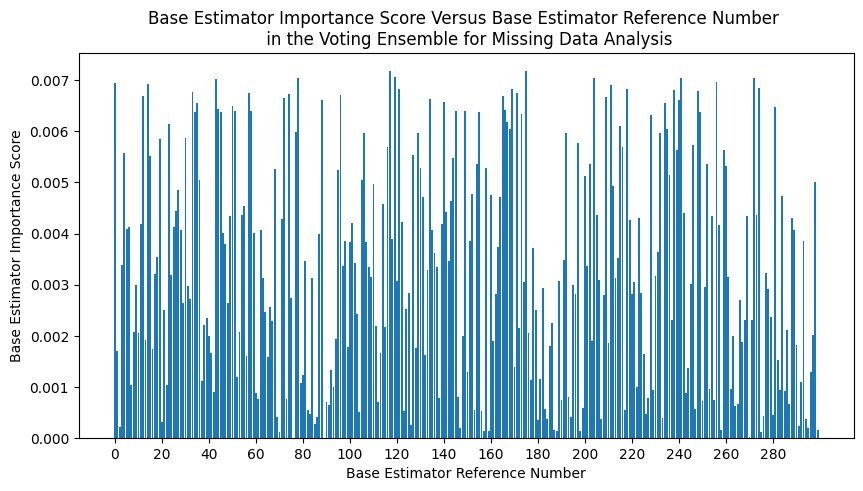

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_imp_voting)), pd.DataFrame(list(feature_imp_voting.items()))[1], label = 'voting ensemble')
plt.title('Base Estimator Importance Score Versus Base Estimator Reference Number \n in the Voting Ensemble for Missing Data Analysis')
plt.xlabel('Base Estimator Reference Number')
plt.ylabel('Base Estimator Importance Score')
plt.xticks(np.arange(0, 300, 20)) 
plt.show()

In [38]:
pred_std = pd.concat([test_data_y_original, base_models_pred.std(axis=1)], axis=1)
pred_std[(pred_std['Maternal mortality ratio (national estimate, per 100,000 live births)'] > 650)]

,"Maternal mortality ratio (national estimate, per 100,000 live births)",0
35,732.0,147.452485
63,1194.0,215.930332
183,1389.0,169.611084
189,833.0,280.123709


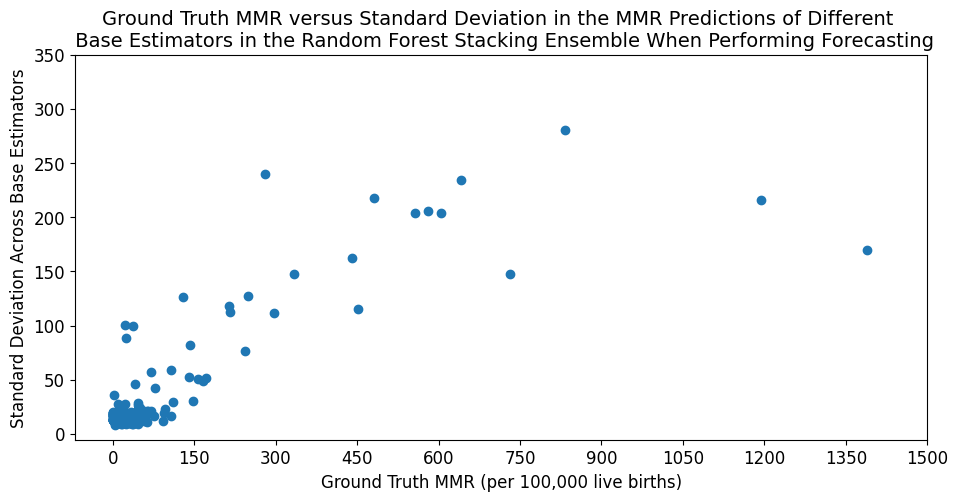

In [41]:
# Plot: Prediction variance vs predicted value
plt.figure(figsize=(11, 5))
plt.scatter(test_data_y_original, base_models_pred.std(axis=1))
plt.title('Ground Truth MMR versus Standard Deviation in the MMR Predictions of Different \n Base Estimators in the Random Forest Stacking Ensemble When Performing Forecasting', fontsize=14)
plt.xlabel('Ground Truth MMR (per 100,000 live births)', fontsize = 12)
plt.ylabel('Standard Deviation Across Base Estimators', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yticks(ticks=[0, 50, 100, 150, 200, 250, 300, 350], labels=[0, 50, 100, 150, 200, 250, 300, 350])
plt.xticks(ticks=[0, 150, 300, 450, 600, 750, 900, 1050, 1200, 1350, 1500], labels=[0, 150, 300, 450, 600, 750, 900, 1050, 1200, 1350, 1500])
plt.show()

Text(0, 0.5, 'Variance Across the Individual Trees in the Random Forest Ensemble')

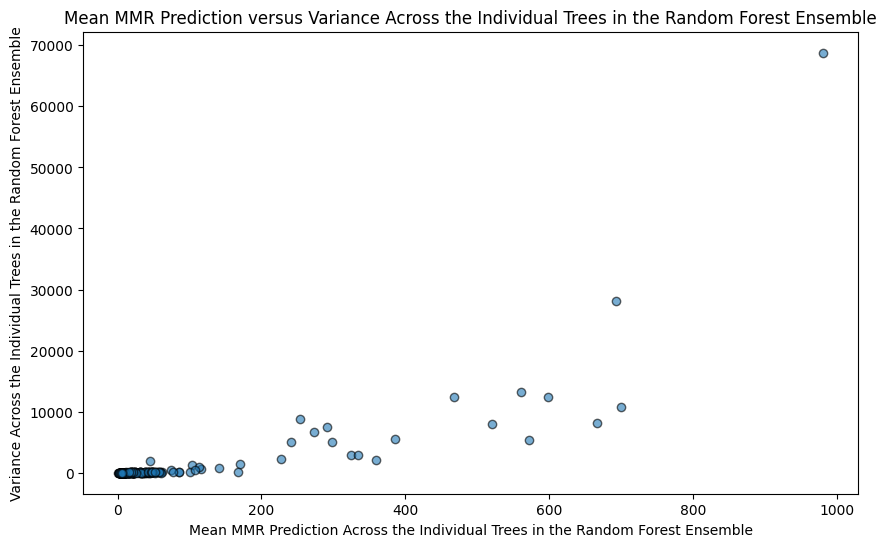

In [15]:
all_tree_preds_original = np.array([tree.predict(stacked_test_predictions_original) for tree in original_rf_ensemble.estimators_])
# Variance across estimators for each sample (axis=0: across trees)
# Shape: (n_samples,)
per_sample_variance = np.var(all_tree_preds_original, axis=0)

#print("Per-sample prediction variance across trees:\n", per_sample_variance)

mean_predictions = np.mean(all_tree_preds_original, axis=0)

# Plot: Prediction variance vs predicted value
plt.figure(figsize=(10, 6))
plt.scatter(mean_predictions, per_sample_variance, alpha=0.6, edgecolor='k')
plt.title('Mean MMR Prediction versus Variance Across the Individual Trees in the Random Forest Ensemble')
plt.xlabel('Mean MMR Prediction Across the Individual Trees in the Random Forest Ensemble')
plt.ylabel('Variance Across the Individual Trees in the Random Forest Ensemble')


In [16]:
test_data_x_original = pd.read_csv('../split_year_data/test/X_test.csv')
test_data_x_original = test_data_x_original.drop(columns=['Unnamed: 0'], axis=1)
test_data_y_original = pd.read_csv('../split_year_data/test/y_test.csv')
test_data_y_original = test_data_y_original.drop(columns=['Unnamed: 0'], axis=1)

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_16770/1714693082.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  re_scores_original[p] = np.abs(original_predictions[p] - test_data_y_original.iloc[p]) / np.maximum(np.abs(original_predictions[p]), np.abs(test_data_y_original.iloc[p]))
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_16770/1714693082.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Income Level', y='Prediction Error', data=re_vs_inc_sorted, palette='Set2')


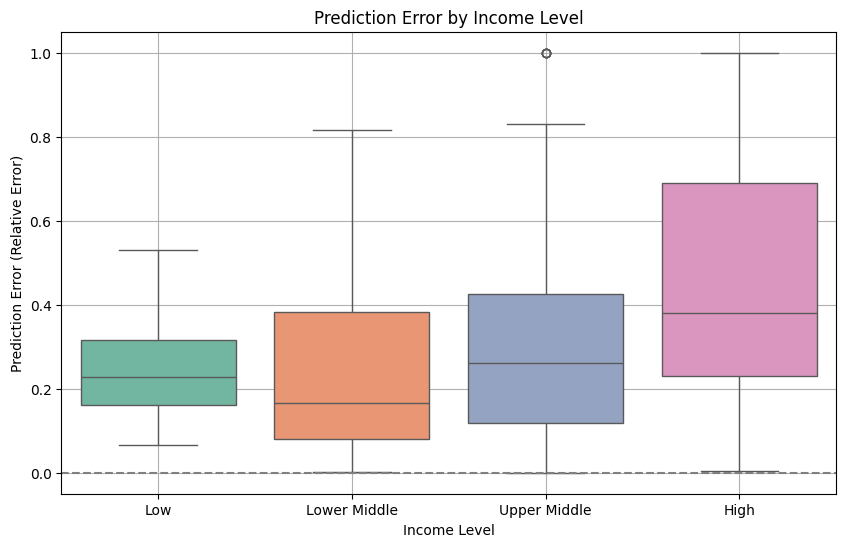

In [17]:
#prediction error versus income level
#to evaluate the models' test_predictions
import seaborn as sns

original_predictions = original_rf_ensemble.predict(stacked_test_predictions_original)
re_scores_original = np.zeros(len(original_predictions))

for p in range(len(original_predictions)):
        re_scores_original[p] = np.abs(original_predictions[p] - test_data_y_original.iloc[p]) / np.maximum(np.abs(original_predictions[p]), np.abs(test_data_y_original.iloc[p]))

test_income_levels = pd.DataFrame(test_data_x_original['income_num'])
test_income_levels.columns = ['income_num']

def income(num):
    if num == 1:
        return 'Low'
    elif num == 2:
        return 'Lower Middle'
    elif num == 3:
        return 'Upper Middle'
    elif num == 4:
        return 'High'

test_income_levels['income'] = test_income_levels['income_num'].apply(income)

re_vs_inc = pd.DataFrame({
    'Income Level': test_income_levels['income'],
    'Prediction Error': re_scores_original
})

income_order = [
    "Low",
    "Lower Middle",
    "Upper Middle",
    "High"
]

re_vs_inc['Income Level'] = pd.Categorical(re_vs_inc['Income Level'], categories=income_order, ordered=True)
re_vs_inc_sorted = re_vs_inc.sort_values(by='Income Level')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Income Level', y='Prediction Error', data=re_vs_inc_sorted, palette='Set2')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Prediction Error by Income Level")
plt.ylabel("Prediction Error (Relative Error)")
plt.xlabel("Income Level")
plt.grid(True)
plt.show()

In [18]:
joblib.dump(re_vs_inc_sorted, f"ensemble/year/prediction_error_inclevel.pkl")

['ensemble/year/prediction_error_inclevel.pkl']

### Visualisations

In [113]:
test_stats.loc[('Original', 'Low'), 'MSE'] = 88585.363533
test_stats.loc[('Original', 'Low'), 'Relative Error'] = 0.253953

test_stats.loc[('Original', 'Lower Middle'), 'MSE'] = 10939.312915
test_stats.loc[('Original', 'Lower Middle'), 'Relative Error'] = 0.245471

test_stats.loc[('Original', 'Upper Middle'), 'MSE'] = 605.909141
test_stats.loc[('Original', 'Upper Middle'), 'Relative Error'] = 0.316232

In [114]:
test_statsm = test_stats[:-2]
test_statsm

,,MSE,MAE,R2,RMSE,Relative Error
Model Type,Type of Sensitivity,,,,,
Original,Low,88585.363533,192.704762,0.499433,270.818504,0.253953
Sensitivity,Low,58700.528321,184.625615,0.599366,242.281919,0.209743
Original,Lower Middle,10939.312915,53.736069,0.815084,96.221364,0.245471
Sensitivity,Lower Middle,7456.104377,54.071824,0.851083,86.348737,0.308994
Original,Upper Middle,605.909141,16.130317,0.633359,25.390919,0.316232
Sensitivity,Upper Middle,606.464571,15.99682,0.655103,24.626501,0.303844


In [117]:
(88585.363533-58700.53)**0.5

172.8723041235929

In [118]:
(3000)**0.5

54.772255750516614

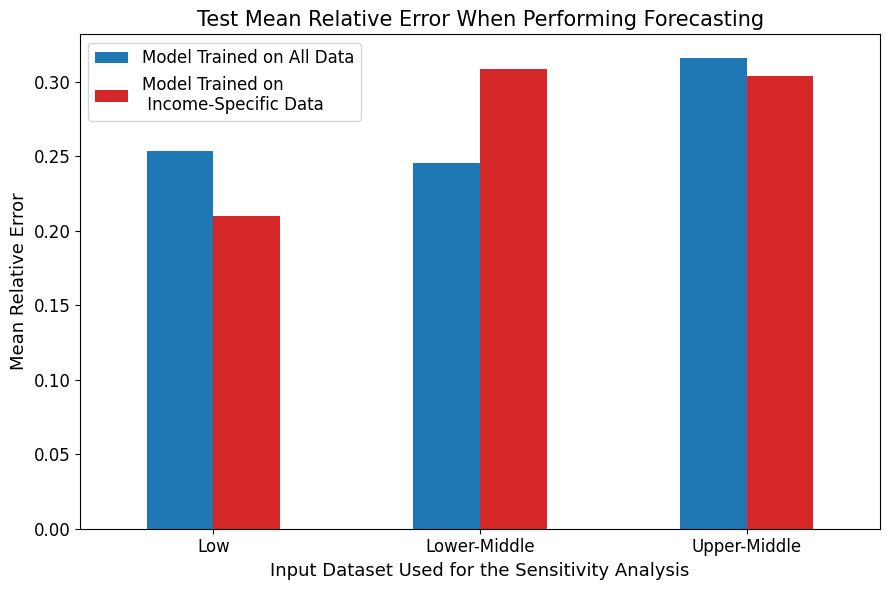

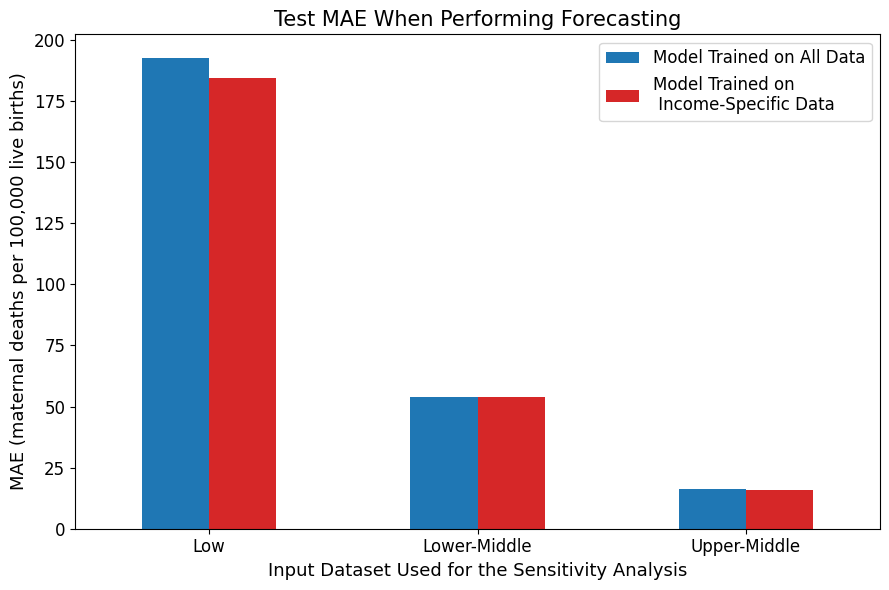

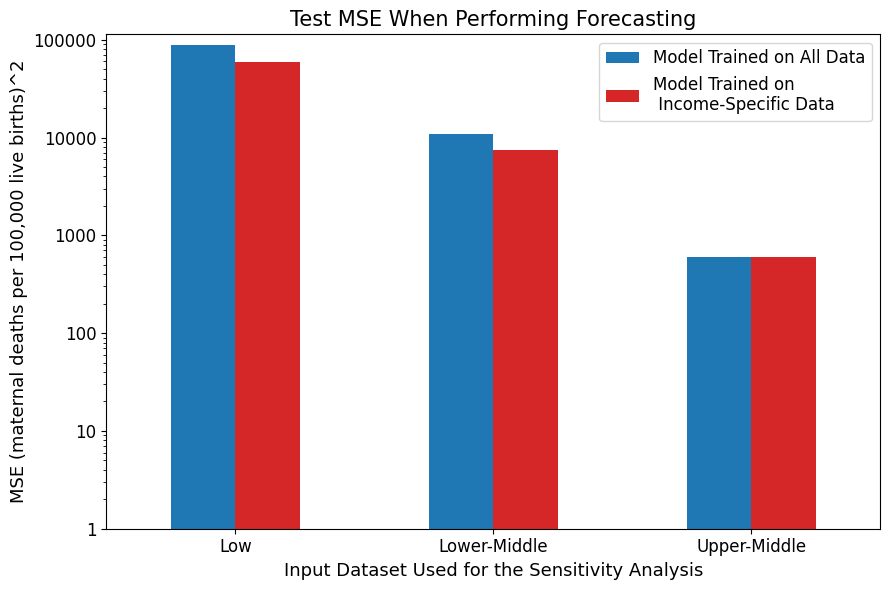

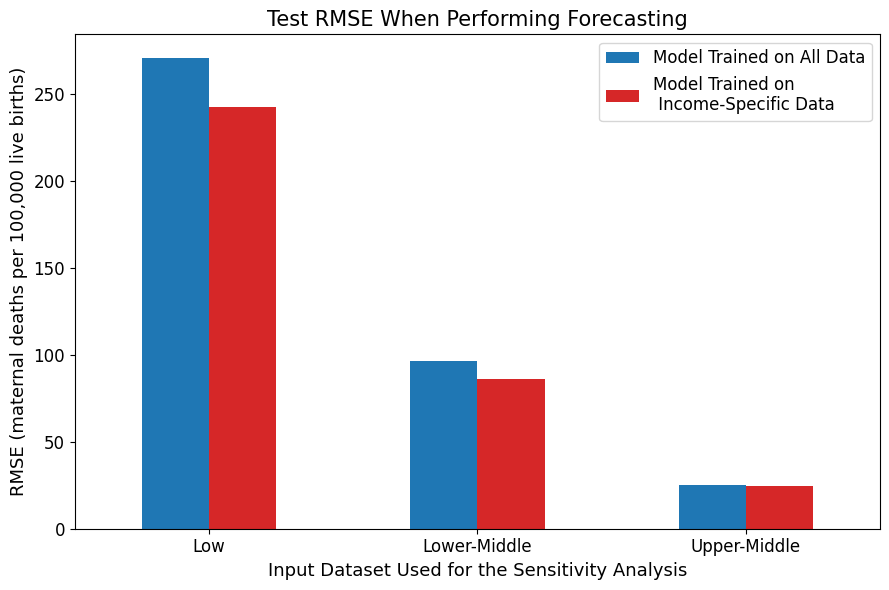

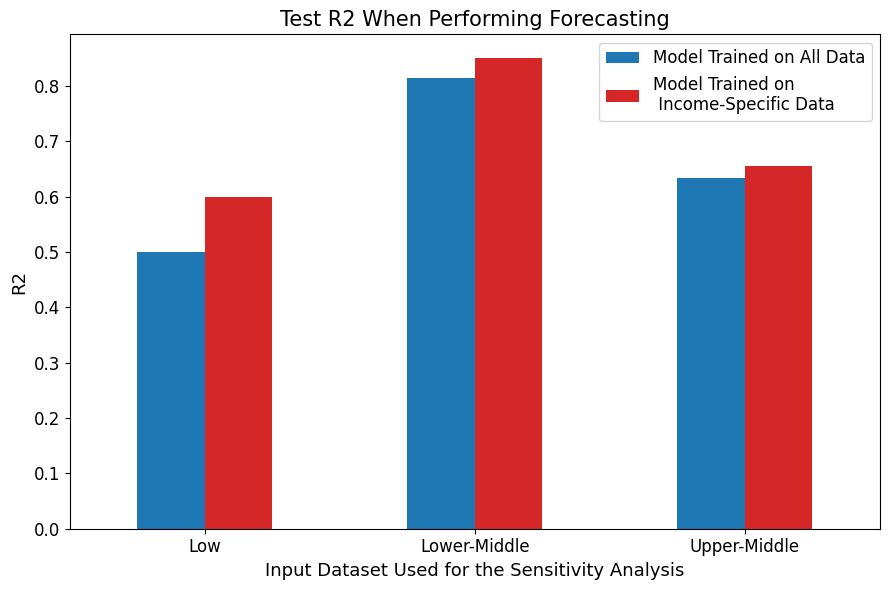

In [115]:
metrics = ['Relative Error', 'MAE', "MSE", 'RMSE', "R2"]

for metric in metrics:
    data_metric = test_statsm[metric].unstack(level='Model Type')
    new_order = ['Low', 'Lower Middle', 'Upper Middle']#, 'High']

    ax = data_metric.plot.bar(rot=0, figsize=(9, 6), color=['#1f77b4', '#d62728'])#, color=bar_colours)     

    if metric == 'Relative Error':
        metric_title = 'Mean Relative Error'
        metric_name = metric_title
    elif metric == 'MAE':
        metric_title = metric
        metric_name = 'MAE (maternal deaths per 100,000 live births)'
    elif metric == 'RMSE':
        metric_title = metric
        metric_name = 'RMSE (maternal deaths per 100,000 live births)'
    elif metric == 'MSE':
        metric_title = metric
        metric_name = 'MSE (maternal deaths per 100,000 live births)^2'
        plt.yscale('log')
        plt.yticks(ticks=[1, 10, 100, 1000, 10000, 100000], labels=[1, 10, 100, 1000, 10000, 100000])
    else:
        metric_title = metric
        metric_name = metric

    plt.title("Test " + metric_title + " When Performing Forecasting", fontsize=15)
    plt.xlabel("Input Dataset Used for the Sensitivity Analysis", fontsize=13)
    plt.ylabel(metric_name, fontsize=13)
    plt.yticks(fontsize=12)
    plt.xticks(ticks=[0, 1, 2], labels=['Low', 'Lower-Middle', 'Upper-Middle'], fontsize=12)
    plt.tight_layout()
    plt.legend(['Model Trained on All Data', 'Model Trained on \n Income-Specific Data'], fontsize=12)
    plt.show()